# Comparison and Visualization of Cursor vs IMU Data

This code was developed to analyze data and generate figures for "Evaluating Mouse Control and Usability Patterns Across Tremor and Non-Tremor Populations"

### Loading necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

### Alignment of IMU with Cursor Data

(-50.0, 50.0)

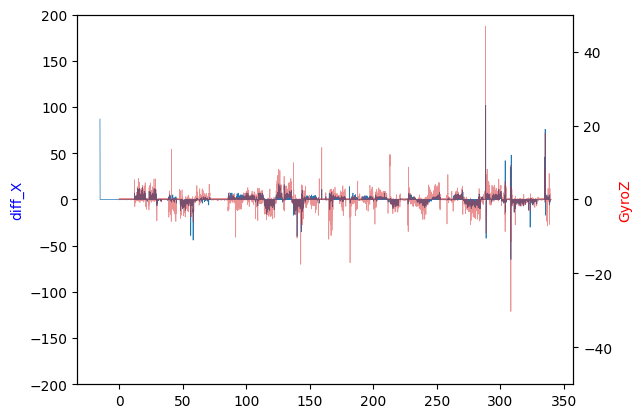

In [17]:
# ------------------------------------------------------------------------------------- #
# Select Participant Gyro Z data aligned with mouse X-velocity
# ------------------------------------------------------------------------------------- #
participant = '1'

# Load Cursor Data
cursor = pd.read_csv("./data/positions_" + participant + ".txt", sep='\t', header=None, names=['time', 'X', 'Y'])
# Identify Times of Clicks
clicks = cursor[cursor['time'] == 'Mouse Click'].index
clicks = cursor.loc[clicks-1]
# Remove non-numerical rows (i.e. ones that state 'Mouse Click')
cursor.dropna(inplace=True)
# Change time to a numeric
cursor['time'] = pd.to_numeric(cursor['time'])
# Offset time by first click so that the IMU and Cursor data are aligned
cursor['time'] = cursor['time'] - float(clicks.iloc[0]['time'])
cursor['diff_X'] = cursor['X'].diff()

# IMU Data
IMU = pd.read_csv("./data/TestTaker" + participant + ".csv")
IMU.columns =['time', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
IMU.columns = IMU.columns.str.strip()
IMU['GyroZ'] = IMU['GyroZ'] - np.mean(IMU['GyroZ'])


# ------------------------------------------------------------------------------------- #
# Plot Data
# ------------------------------------------------------------------------------------- #

fig, ax1 = plt.subplots()

# Primary y-axis
ax1.plot(cursor['time'], cursor['diff_X'], color='tab:blue', linewidth=0.5)
ax1.set_ylabel('diff_X', color='blue')
ax1.set_ylim([-200, 200])

# Secondary y-axis
ax2 = ax1.twinx()
ax2.plot(IMU['time'], IMU['GyroZ'], color='tab:red', linewidth=0.5, alpha=0.5)
ax2.set_ylabel('GyroZ', color='red')
ax2.set_ylim([-50,50])


## Adding IMU data column to cursor data 
The column will include the value of the IMU data that is closest in time to the cursor data

c:\Users\ahickers\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


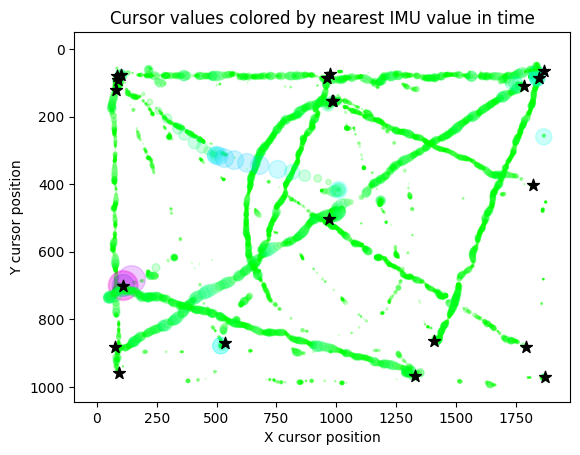

In [18]:
# ------------------------------------------------------------------------------------- #
# Convert Cursor and IMU data to NumPy for efficiency
# ------------------------------------------------------------------------------------- #
cursor_times = cursor['time'].to_numpy()
IMU_times = IMU['time'].to_numpy()
IMU_values = IMU['GyroZ'].to_numpy()

# Sort indices of IMU and Cursor times
indices = np.searchsorted(IMU_times, cursor_times)

# Find the closest index for the IMU at the time of cursor data
closest_indices = []
for i, t in enumerate(cursor_times):
    idx = indices[i]
    if idx > 0 and (idx == len(IMU_times) or abs(t - IMU_times[idx-1]) <= abs(t - IMU_times[idx])):
        closest_indices.append(idx - 1)
    else:
        closest_indices.append(idx)

# Based on closest index, make a Cursor time match IMU column 
matched_IMU_values = IMU_values[closest_indices]


# ------------------------------------------------------------------------------------- #
# Plot Data
# ------------------------------------------------------------------------------------- #
fig, ax = plt.subplots()

plt.scatter(cursor['X'], cursor['Y'], c=matched_IMU_values, alpha=0.2, s=matched_IMU_values*10, cmap='gist_rainbow')

plt.scatter(clicks['X'], clicks['Y'],
            color='k',       # solid fill
            edgecolors='k', # optional border
            s=80,               # marker size
            marker='*',         # filled circle
            zorder=2)          # fully opaqueplt.colorbar(label='GyroZ')

plt.xlabel('X cursor position')
plt.ylabel('Y cursor position')
ax.invert_yaxis()
plt.title('Cursor values colored by nearest IMU value in time')
plt.show()

